<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/GATr_Deep_Learning_Project/blob/main/GATr_deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!git clone https://github.com/FedericoRaschiatore0123/GATr_Deep_Learning_Project.git

Cloning into 'GATr_Deep_Learning_Project'...
remote: Enumerating objects: 4302, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 4302 (delta 139), reused 141 (delta 108), pack-reused 4120
Receiving objects: 100% (4302/4302), 1.70 GiB | 26.48 MiB/s, done.
Resolving deltas: 100% (210/210), done.
Updating files: 100% (4005/4005), done.


In [2]:
#librerie
!pip install pytorch_lightning --quiet
!pip install h5py
!pip install trimesh
!pip install torch_geometric
!pip install pyquaternion
!pip install clifford
!pip install einops

from torchmetrics.classification import BinaryAccuracy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch_geometric.data
from torch_geometric.data import Data
from torch.utils.data import random_split, ConcatDataset, Subset
from pyquaternion import Quaternion
import clifford as cf
import pytorch_lightning as pl
import math
from einops import rearrange

import h5py
import os
import trimesh
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00


#Global Variables

In [46]:
# create a dictionary of global variables
global_variables = {

    'single_path' : '/content/GATr_Deep_Learning_Project/single/',
    'bifurcating_path' : '/content/GATr_Deep_Learning_Project/bifurcating/',

    'length_data' : 100,
    'mv_dimension' : 16,
    'mv_channels' :4,
    'hidden_dim_mv' : 8,
    'num_heads' : 2,
    'out_channels' : 1,
    'num_classes' : 2,
    "patience" : 3,
    "factor" : 0.1,

    'batch_size' :  64,
    'num_workers' : 2,

    'dim_GA' : 16,
    'hidden_dim' : 8,

    'geometric_guidance' : '/content/GATr_Deep_Learning_Project/data/geometric_product.pt',
    'outer_guidance' : '/content/GATr_Deep_Learning_Project/data/outer_product.pt',
}

#Get device

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

#Show data

In [5]:
# Samples of the dataset are shown for both classes (single, bifurcating) using trimesh

single_list = os.listdir(global_variables['single_path'])

with h5py.File(global_variables['single_path'] + single_list[random.randint(0, len(single_list))] , 'r') as file:

    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

In [6]:
bifurcating_list = os.listdir(global_variables['bifurcating_path'])

with h5py.File(global_variables['bifurcating_path'] + bifurcating_list[random.randint(0, len(bifurcating_list))] , 'r') as file:
    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

In [7]:
def check_balancing(dataset):
  """
  This function is used to visualize the distribution of the data between the two classes through an histogram.
  Input:
    dataset (torch.Tensor)

  Output:
    histogram representing the distribution of the samples
  """
  label = []
  for _ , element in enumerate(dataset):
    label.append(element[-1])

  categories = ['Single ' +  str(label.count(0)), 'Bifurcating ' +  str(label.count(1))]

  fig, ax = plt.subplots(figsize = (8,5))

  bars = ax.bar(
      categories,
      [label.count(0), label.count(1)],
      align = 'center'
    )

  ax.set_xlabel('Labels')
  ax.set_ylabel('Number of occurences')

  plt.ylim(ymax = len(label))
  plt.show()

# Geometric Algebra

Geometric algebra $G_{3,0,1}$ is used to extend the space $\mathbb{R}^{3}$ into an equivalent 16-dimensional space that encodes the basic geometric elements (points, planes, lines...) as well as transformations such as rotations, translations and reflections. $G_{3,0,1}$ indicates that the space is characterized by four generators ($e_{0}$, $e_{1}$, $e_{2}$, $e_{3}$). In particular, three of them ($e_{1}$, $e_{2}$, $e_{3}$) satisfy $e_{i}e_{i} = 1$, while the remaining one satisfies $ e_{0}e_{0} = 0 $. TODO: add source

The basis components of the multivector associated to the G_{3,0,1} algebra are obtained by considering every possible multiplicative combination of the basis elements. Elements of different grade are thus obtained:

Grade 0 ($1$): scalars in the G.A. \\
Grade 1 ($e_{0}$, $e_{i}$): vectors in the G.A. \\
Grade 2 ($e_{0i}$, $e_{ij}$); bivectors in the G.A. \\
Grade 3 ($e_{0ij}$, $e_{ijk}$): trivectors in the G.A. \\
Grade 4 ($e_{0123}$): pseudoscalars in the G.A. \\

The multivector representation associated to the Geometric Algebra G_{3,0,1} will thus be composed of a total of 16 elements.

Scalars will be represented by grade 0 elements, planes by grade 1 elements, lines by grade 2 elements, points by grade 3 elements and pseudoscalar by grade 4 elements.

## Definition of the embeddings
Each sample of the dataset represents a portion of an artery and is characterized by a set of 3D points (pos), a set of plane faces each delimited by 3 points (faces), a set of wall sheer stress vectors (wss), a set of inlet indeces (inlet_idcs), and a set of pressure values (pressure).
The data is encoded using the definitions provided in arcicle TODO cite, and shown below. Before the embedding procedure, the data is standardized. \\
NOTE: The inlet indices are a set of natural numbers that identify the indices of the 3D points that lie on the entrance border of the artery. For the task of classifying the arteries, they are not as rich in information as the other components of the data samples. Thus, the multivectors corresponding to the inlet indeces are not included in the total concatenated embedding of the samples. Nevertheless, the definition of their embedding is provided for the sake of completeness.

<center>

![Baseline](https://drive.google.com/uc?export=download&id=1f7fpn1U784RmHogDEwdFrd8ptaMhVS1C)

</center>

In [8]:
def embed_pos_mv_16(pos):
    """
    Embeds the pos torch tensor as a 16-dimensional G_{3,0,1} multivector

    Args:
        pos (torch.Tensor): tensor of input points with shape (n_elements, 3)

    Returns:
        pos_mv torch.Tensor: tensor of multivectors of dimension 16 with shape (1, n_elements, 1, 16)
    """
    # Positions in Euclidean geometry can be embedded as points in G_{3,0,1} algebra

    # Get the number of points and the dimensionality
    n_elements = pos.shape[0]
    dim = pos.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 14] = 1 # homogeneous component, e_{123}
    multivector[:, 11] = pos[:, 0] # x, e_{023}
    multivector[:, 12] = pos[:, 1] # y, e_{013}
    multivector[:, 13] = pos[:, 2] # z, e_{012}

    pos_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return pos_mv

In [9]:
def embed_face_mv_16(face):
    """
    Embeds the face torch tensor as a 16-dimensional G_{3,0,1} multivector

    Input:
        face torch.Tensor of size (n_elements, 3)
    Output:
        mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # An oriented surface in Euclidean geometry characterized by
    #   the normal vector n to the surface itself can be embedded as an oriented
    #   plane in G_{3,0,1} algebra


    # Get the number of points and the dimensionality of the space
    n_elements = face.shape[0]
    dim = face.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 2] = face[:, 0] # e_{1}
    multivector[:, 3] = face[:, 1] # e_{2}
    multivector[:, 4] = face[:, 2] # e_{3}

    face_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return face_mv

In [10]:
def embed_wss_mv_16(wss):
    """
    Embeds the wss vectors as a 16 dimensional G_{3,0,1} multivector
    Input:
      wss torch.Tensor of size (n_elements, 3)
    Output:
      wss_mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # A 3D vector in the Euclidean space can be embedded as a translation in G_{3,0,1} algebra

    n_elements = wss.shape[0]
    dim = wss.shape[1]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 0] = 1
    multivector[:, 5] = 0.5*wss[:, 0] # e_{01}
    multivector[:, 6] = 0.5*wss[:, 1] # e_{02}
    multivector[:, 7] = 0.5*wss[:, 2] # e_{03}

    wss_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return wss_mv

In [11]:
def embed_inlet_mv_16(inlet):
    """
    Embeds the inlet torch tensor as a 16 dimensional G_{3,0,1} multivector
    Input:
        inlet torch.Tensor of size (n_elements, 1)
    Output:
        inlet_mv torch.Tensor of size (1, n_elements, 1, 16)
    """
    # Inlet indexes can be embedded as scalars in G_{3,0,1} algebra

    n_elements = inlet.shape[0]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])
    multivector[:, 0] = inlet[:]

    inlet_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

    return inlet_mv

In [12]:
def embed_pressure_mv_16(pressure):
  """
  Embeds the pressure torch tensor as a 16-dimensional G_{3,0,1} multivector
  Input:
    pressure torch.Tensor of size (n_elements, 1)
  Output:
    pressure_mv torch.Tensor of size (1, n_elements, 1, 16)
  """

  n_elements = pressure.shape[0]

  # Initialize the multivector
  multivector = torch.zeros(n_elements, global_variables['dim_GA'])

  multivector[:,0] = pressure[:]
  pressure_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

  return pressure_mv

In [13]:
def embed_complete_mv_16(sample_path):
  """
  Embeds the artery sample into a concatenation of 4 16-dimensional multivectors in G_{3,0,1}.
  Each of the 4 multivectors embeds a different feature of the artery: pos, face, wss, pressure
  The data is standardized before the embedding
  Input:
    sample_path: path to the artery sample saved in hdf5 format
  Output:
    sample_embedding: torch.Tensor of size (1, length_data, 4, 16)
        where length_data is the number of points in the samples considered for the embedding
  """

  with h5py.File(sample_path, 'r') as f:
    # extract torch tensor for pos
    pos_data = f['pos'][:global_variables['length_data']]
    pos_torch = torch.tensor(pos_data[:])
    pos_torch_norm = (pos_torch - torch.mean(pos_torch)) / torch.std(pos_torch)

    # extract torch tensor for face
    face_data = f['face'][:global_variables['length_data']]
    face_torch = torch.tensor(face_data[:])

    # extract torch tensor for wss
    wss_data = f['wss'][:global_variables['length_data']]
    wss_torch = torch.tensor(wss_data[:])
    wss_torch_norm = (wss_torch - torch.mean(wss_torch)) / torch.std(wss_torch)

    # extract torch tensor for pressure
    pressure_data = f['pressure'][:global_variables['length_data']]
    pressure_torch = torch.tensor(pressure_data[:])
    pressure_torch_norm = (pressure_torch - torch.mean(pressure_torch)) / torch.std(pressure_torch)

  # Get the multivector embeddings for each torch tensor
  pos_mv_16 = embed_pos_mv_16(pos_torch_norm)
  face_mv_16 = embed_face_mv_16(face_torch)
  wss_mv_16 = embed_wss_mv_16(wss_torch_norm)
  pressure_mv_16 = embed_pressure_mv_16(pressure_torch_norm)

  sample_embedding = torch.cat(
      [pos_mv_16, face_mv_16, wss_mv_16, pressure_mv_16], dim = 2)

  return sample_embedding

In [14]:
# Use of embed_complete_mv_16

sample_path = "/content/GATr_Deep_Learning_Project/single/sample_0000.hdf5"
sample_embedding = embed_complete_mv_16(sample_path)
print(sample_embedding.shape)

torch.Size([1, 100, 4, 16])


## Geometric Algebra Transformations

Basic transformation operations are defined using the definitions provided in article TODO cite. The defined transformations are:


*   Reflection with respect to a plane;
*   Translation;
*   Reflection with respect to a point;
*   Rotation identified by a quaternion.







In [15]:
def embed_plane_reflection_mv_16(normal, d):
  """
  Embeds a plane reflection transformation given a normal vector and an origin shift
  as a 16-dimensional multivector in G_{3,0,1}
  Input:
    normal: torch.Tensor (1, 3) normal to the plane
    d: origin shift
  Output:
    pr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the plane reflection
  """
  # Initialize the multivector
  plane_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  plane_reflection_mv_16[0,1] = d
  plane_reflection_mv_16[0,2] = normal[0]
  plane_reflection_mv_16[0,3] = normal[1]
  plane_reflection_mv_16[0,4] = normal[2]

  pr_mv_16 = plane_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pr_mv_16



In [16]:
def embed_translation_mv_16(t):
  """
  Embeds a translation by a vector t in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Input:
    t: torch.Tensor of size (1, 3) representing a translation in the 3D space
  Output:
    tr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the translation
  """
  # Initialize the multivector
  translation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  translation_mv_16[0,0] = 1 # homogeneous component
  translation_mv_16[0,5] = 0.5*t[0]
  translation_mv_16[0,6] = 0.5*t[1]
  translation_mv_16[0,7] = 0.5*t[2]

  tr_mv_16 = translation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return tr_mv_16

In [17]:
def embed_point_reflection_mv(p):
  """
  Embeds a reflection with respect to a point p in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Input:
    p: torch.Tensor of size (1,3) representing a point in 3D
  Output:
    pt_ref_mv_16: torch.Tensor of size (1,1,1,16) representing the point reflection
  """
  # Initialize the multivector
  point_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  point_reflection_mv_16[0,11] = p[0]
  point_reflection_mv_16[0,12] = p[1]
  point_reflection_mv_16[0,13] = p[2]
  point_reflection_mv_16[0,14] = 1

  # Reshape to match the shape of the other multivectors
  pt_ref_mv_16 = point_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pt_ref_mv_16

In [18]:
def embed_quaternion_rotation_mv_16(rot_axis, alpha):
  """
  Embeds a rotation defined by a quaterion through the axis angle rotation representation
  Input:
    rot_axis: list of size 1x3 representing the axis of the rotation [r1,r2,r3]
    alpha: float representing the angle of the rotation
  Output:
    quat_rot_mv_16: torch.Tensor of size (1,1,1,16) representing a rotation quaternion rotation
  """
  quaternion = Quaternion(axis=rot_axis, angle=alpha)

  # Initialize the multivector
  quaternion_rotation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  quaternion_rotation_mv_16[0, 0] = quaternion.w
  quaternion_rotation_mv_16[0, 8] = quaternion.x
  quaternion_rotation_mv_16[0, 9] = quaternion.y
  quaternion_rotation_mv_16[0, 10] = quaternion.z

  quat_rot_mv_16 = quaternion_rotation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return quat_rot_mv_16

#Blades

The projection of a multivector $x$ in the subspace of grade $k$ is denoted as the $\bf{blade}$ of grade $k$ of the multivector. Blades are used to define an equilinear map $\phi$ between two elements of the multivector space:

$$ \phi(x) = \sum_{k=0}^{d+1}w_{k}<x>_{k} + \sum_{k=0}^{d}v_{k} e_{0}<x>_{k}$$

Where $d$ is the spatial dimensions of the algebra $G_{d,0,1}$,  $w_{k}$ is the coefficient associated to the blade of grade $k$ of the multivector, $v_{k}$ is the coefficient associated to the blade of grade $k$ multiplied by base element $e_{0}$.

In the definitions below, $w_{blade}$ denotes the blade of grade $k$ ($<x>_{k}$) and $v_{blade}$ denotes the blade of grade $e_{0}$ multiplied by the blade of grade $k$ ($e_{0}<x>_{k}$).

In [19]:
def extract_blades(mv, layout):
    """
    Input:
      mv: torch.Tensor multivector of size [1, global_variables['dim_GA]]
      layout: clifford layout of the geometric algebra

    Output:
      blades (torch.Tensor):
            - w_{k}: blade projections of mv
            - v_{k}: geometric product between e_0 and the blade projections w_{k}
    """

    # mv: torch.Tensor [1, 16]
    cf_mv = layout.MultiVector(mv.numpy())

    w_blade_array = []
    v_blade_array = []
    blade_array = []

    grades = len(cf_mv.grades())

    for grade in range(grades):
        # elements w_{k} (5 elements)
        cf_w_blade = cf_mv(grade)  # mv in clifford
        coeffs = list(cf_w_blade.value)
        blade_torch = torch.tensor(coeffs)
        w_blade_array.append(blade_torch)

    for grade in range(grades-1):  # end at num_blades-1
        # elements v_k (4 elements)
        cf_blade = cf_mv(grade)
        cf_v_blade = e0^cf_blade  # Use the geometric product to extract v-blades
        coeffs = list(cf_v_blade.value)
        blade_torch = torch.tensor(coeffs)
        v_blade_array.append(blade_torch)

    blades = torch.stack(w_blade_array + v_blade_array)

    return blades

In [20]:
def blade_matrices(blades):
  """
  Input:
    blades (torch.Tensor): blade projection of a multivector
          containing torch.Tensors of type w_{k} and v_{k}

  Output:
    matrices_stack (torch.Tensor): stack of matrix operators that represent the blades
  """

  matrices = []
  for _, blade in enumerate(blades):

    matrix = torch.zeros((global_variables['dim_GA'], global_variables['dim_GA']))
    for i, element in enumerate(blade):
      if element.int() != 0:
        matrix[i][element.int()-1] = 1
    matrices.append(matrix)

    matrices_stack = torch.stack(matrices)

  return matrices_stack


# Operations between multivectors
The inner, outer, and geometric product between multivectors are defined by applying the Einstein coefficients formalism on torch tensors.

In [21]:
# instantiate clifford G_{3,0,1} algebra
layout, blades = cf.Cl(p=3, q=0, r=1, firstIdx=0)
locals().update(blades)

print('PGA blades: ', blades)
print('PGA layout: ', layout)

PGA blades:  {'': 1, 'e0': (1^e0), 'e1': (1^e1), 'e2': (1^e2), 'e3': (1^e3), 'e01': (1^e01), 'e02': (1^e02), 'e03': (1^e03), 'e12': (1^e12), 'e13': (1^e13), 'e23': (1^e23), 'e012': (1^e012), 'e013': (1^e013), 'e023': (1^e023), 'e123': (1^e123), 'e0123': (1^e0123)}
PGA layout:  Layout([0, 1, 1, 1], ids=BasisVectorIds.ordered_integers(4, first_index=0), order=BasisBladeOrder.shortlex(4), names=['', 'e0', 'e1', 'e2', 'e3', 'e01', 'e02', 'e03', 'e12', 'e13', 'e23', 'e012', 'e013', 'e023', 'e123', 'e0123'])


In [22]:
def get_mask_product():

    """
    Function that generates a multivector mask that contains 0 if the corresponding multivector blade contains e0, 1 otherwise
    Output:
      mask (torch.Tensor)
    """

    mv = torch.ones(global_variables['dim_GA'])
    cf_mv = layout.MultiVector(mv.numpy())
    prod = e0^cf_mv
    print(prod)
    coeffs = list(prod.value)
    mask_complement = torch.Tensor(coeffs)
    mask = 1- mask_complement

    return mask

In [23]:
# TODO: add reference for these three functions below inner, geometric, outer product
def inner_product(x, y):
    """
    Computes the inner product of multivectors f(x,y) = <x, y> = <~x y>_0.

    Sums over the 16 multivector dimensions.

    Equal to `geometric_product(reverse(x), y)[..., [0]]` (but faster).

    Input:
      x : torch.Tensor with shape (..., 16) or (..., channels, 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
      y : torch.Tensor with shape (..., 16) or (..., channels, 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns:
    outputs : torch.Tensor with shape (..., 1)
        Result. Batch dimensions are result of broadcasting between x and y.
    """

    guidance = torch.load(global_variables['geometric_guidance']).to_dense()

    reversal_index = torch.ones(16)[5:15] = -1

    inner_product_mask = (torch.diag(guidance[0]) * reversal_index).bool()

    selector = torch.arange(16)[inner_product_mask]

    x = x[..., selector]
    y = y[..., selector]

    outputs = torch.einsum(
        "... i, ... i -> ...",
        x,
        y
    )

    # We want the output to have shape (..., 1)
    outputs = outputs.unsqueeze(-1)

    return outputs

In [99]:
def outer_product(x, y):
    """
    Computes the outer product `f(x,y) = x ^ y`.

    Inputs
    x : torch.Tensor with shape (..., 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
    y : torch.Tensor with shape (..., 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns
    -------
    outputs : torch.Tensor with shape (..., 16)
        Result. Batch dimensions are result of broadcasting between x, y, and coeffs.
    """

    guidance = torch.load(global_variables['outer_guidance']).to_dense()

    outputs = torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance.float().to(device),
        x,
        y
    )

    return outputs

In [95]:
def geometric_product(x, y):
    """Computes the geometric product f(x,y) = xy.

    Parameters
    ----------
    x : torch.Tensor with shape (..., 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
    y : torch.Tensor with shape (..., 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns
    -------
    outputs : torch.Tensor with shape (..., 16)
        Result. Batch dimensions are result of broadcasting between x, y, and coeffs.
    """

    # Select kernel on correct device
    guidance = torch.load(global_variables['geometric_guidance']).to_dense()

    # Compute geometric product
    outputs =  torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance.float().to(device),
        x,
        y
    )

    return outputs

## Join operator
The join operation between two multivectors is defined as
$$ JOIN(x, y) = (x^{*} \wedge y^{*})^{*}, $$ where $\wedge$ denotes the outer product between multivectors and ${(\cdot)}^{*}$ denotes the dual of a multivector. \\

In [97]:
def dualize_mv(mv):

  '''
  Returns the dual of multivector mv

  Input:
    mv: torch.Tensor of size [1, global_variables['dim_GA']]

  Output:
    dualized_mv: torch.Tensor of size [1, global_variables['dim_GA']], dual multivector of mv
  '''

  mv_size = global_variables['dim_GA']
  dualization_map = torch.zeros([mv_size, mv_size])
  for i in range(mv_size):
    dualization_map[i, mv_size-1-i] = 1 # matrix with 1 on the antidiagonal, 0 elsewhere

  dualized_mv = torch.matmul(mv, dualization_map.to(device))

  return dualized_mv

In [27]:
# join operation
def join_operation(mv_1, mv_2):
  '''
  Performs the join operation between two multivectors

  Input:
    mv_1: torch.Tensor of size [1, global_variables['dim_GA']]
    mv_2: torch.Tensor of size [1, global_variables['dim_GA']]

  Output:
    joined_mv: torch.Tensor of size [1, global_variables['dim_GA']], result of the join operation
  '''

  mv_1_dual = dualize_mv(mv_1)
  mv_2_dual = dualize_mv(mv_2)
  outer_prod = outer_product(mv_1_dual, mv_2_dual)
  print(outer_prod.shape)
  joined_mv = dualize_mv(outer_prod)

  return joined_mv


In [28]:
# example of use of the functions above:
# TODO: questo si potrebbe togliere.

mv_1 = torch.Tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
mv_2 = torch.Tensor([16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

geometric_prod_mv = geometric_product(mv_1,mv_2)
print('multivector 1: ', mv_1)
print('multivector 2: ', mv_2)
print('geometric product mv_1*mv_2: ', geometric_prod_mv)

multivector 1:  tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.])
multivector 2:  tensor([16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1.])
geometric product mv_1*mv_2:  tensor([ -68., -206.,  120.,  202., -284.,  420.,  176., -524.,  342., -104.,
         398.,  444.,  228.,  500.,  404.,  342.])


#Dataset Preparation

In [29]:
class DataModule(pl.LightningDataModule):
  """
  Class DataModule used for handling data loading, preparation, and splitting
  into training, validation, and test sets.
  """

  def __init__(self, path_single, path_bifurcating):

    super(DataModule,self).__init__()

    self.single_data_path = path_single
    self.bifurcating_data_path = path_bifurcating
    self.dataset = None

  def prepare_data(self):
    """
    This method is used for loading and shuffling data
    """
    single_dataset, label_single = self.load_data(self.single_data_path,  bifurcating=False)
    bifurcating_dataset, label_bifurcating = self.load_data(self.bifurcating_data_path,  bifurcating=True)
    indices = torch.randperm(label_single.shape[0] + label_bifurcating.shape[0])

    self.dataset = self.shuffle_and_combine_datasets(single_dataset, bifurcating_dataset, indices)
    self.label = self.shuffle_and_combine_datasets(label_single, label_bifurcating, indices)

  def setup(self, stage=None):
    """
    This method is used for setting up the datasets for training, validation, and testing.

    Inputs:
      stage (str, optional): Stage of the training process (fit, test). Default is None.
    """
    train, validation, test = self.split_dataset(list(zip(self.dataset, self.label)))

    if stage == "fit" or stage is None:
      self.train_dataset = train
      self.validation_dataset = validation

    if stage == "test" or stage is None:
      self.test_dataset = test

  def load_data(self, path, bifurcating=False):
    # TODO: ask Federico about the bifurcating flag
    """
    This method is used for loading the data and assigning a label to each sample.

    Inputs:
      path (str): Path to the dataset.
      bifurcating (bool):

    Output:
      data (torch.Tensor): Loaded data.
      label (torch.Tensor): Corresponding labels.
    """
    data = []
    for file in os.listdir(path):
        data.append(embed_complete_mv_16(path + file))

    label = torch.ones(len(data)) if bifurcating else torch.zeros(len(data))
    data = torch.stack(data).squeeze()

    return data , label


  def shuffle_and_combine_datasets(self, dataset1, dataset2, indices):
      """
      This method is used to combine and shuffle the datasets
      Input:
        dataset1 (torch.Tensor): first dataset
        dataset2 (torch.Tensor): second dataset
        indices (torch.Tensor): indices used for shuffling

      Output:
        shuffled_dataset (torch.Tensor): shuffled dataset
      """
      combined_dataset = ConcatDataset([dataset1, dataset2])
      shuffled_dataset = Subset(combined_dataset, indices)

      return shuffled_dataset

  def split_dataset(self, dataset, train_ratio=0.7, validation_ratio=0.2, test_ratio=0.1):
      """
      This method is used to split the dataset into training, validation and test set
      Inputs:
        dataset (torch.Tensor): entire dataset
        train_ratio (float)
        validation_ratio (float)
        test_ratio (float)

      Output:
        train_dataset, validation_dataset, test_dataset (torch.Tensor)
      """

      total_size = len(dataset)
      train_size = int(total_size * train_ratio)
      validation_size = int(total_size * validation_ratio)
      test_size = total_size - train_size - validation_size

      train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

      return train_dataset, validation_dataset, test_dataset

  def train_dataloader(self):
      """
      This method returns the train dataloader
      """
      return DataLoader(
          self.train_dataset,
          shuffle = True,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def val_dataloader(self):
      """
      This method returns the validation dataloader
      """
      return DataLoader(
          self.validation_dataset,
          shuffle = False,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def test_dataloader(self):
      """
      This method returns the test dataloader
      """
      return DataLoader(
          self.test_dataset,
          shuffle = False,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def train_dataset(self):
    """
    This method returns the training dataloader
    """
    return self.train_dataset

  def val_dataset(self):
    """
    This method returns the validation dataloader
    """
    return self.val_dataset

  def test_dataset(self):
    """
    This method returns the test dataloader
    """
    return self.test_dataset

In [30]:
# TODO: queste sono prove o servono per il codice?
data_module_prove = DataModule(global_variables['single_path'], global_variables['bifurcating_path'])

data_module_prove.prepare_data()
data_module_prove.setup(stage="fit")
train_dataloader = data_module_prove.train_dataloader()

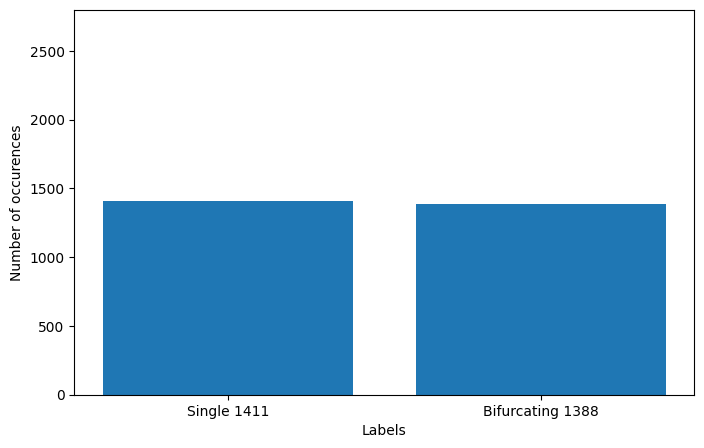

In [31]:
# Visualization of the distribution of the data between the two classes
check_balancing(data_module_prove.train_dataset)

# Baseline Transformer

TODO: qui bisognerebbe spiegare un po' le scelte fatte: perche' questo transformer, perche' questo embedding...
<center>

![Baseline](https://drive.google.com/uc?export=download&id=1gg8ec3XNFPuOmF4RM_eJpmflVb9NDwFq)

</center>

In [32]:
class MultiHeadAttention(nn.Module):
  """
  Multi-head attention module for the baseline transformer
  """
  def __init__(self, hidden_dim, num_heads, dropout=0.1):
      super(MultiHeadAttention, self).__init__()
      assert hidden_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

      self.hidden_dim = hidden_dim
      self.num_heads = num_heads
      self.head_dim = hidden_dim // num_heads

      self.query = nn.Linear(self.head_dim, self.head_dim)
      self.key = nn.Linear(self.head_dim, self.head_dim)
      self.value = nn.Linear(self.head_dim, self.head_dim)

  def forward(self, x):

      x = x.view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose( 1, 2 )

      q = self.query(x)
      k = self.key(x)
      v = self.value(x)

      att = self.att_score(q, k, v)

      out = att.transpose(1, 2).reshape(x.shape[0], x.shape[2], self.hidden_dim)

      return out

  def att_score(self, q, k, v):
      attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

      attn_probs = torch.softmax(attn_scores, dim=-1)
      output = torch.matmul(attn_probs, v)
      return output


In [33]:
class Encoder(nn.Module):
  """
  Encoder module for the baseline transformer
  """
  def __init__(self, input_dim, hidden_dim, num_heads, dropout = 0.1):
    super(Encoder, self).__init__()

    self.multi_head_attention = MultiHeadAttention(hidden_dim, num_heads)

    self.feedforward = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim)
    )

    self.layer_norm1 = nn.LayerNorm(hidden_dim)
    self.layer_norm2 = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):

    att = self.multi_head_attention(x)

    norm = self.layer_norm1( x + self.dropout(att))

    ff = self.feedforward(norm)

    out = self.layer_norm2( norm + self.dropout(ff))

    return out

In [34]:
class Transformer(nn.Module):
  """
  Entire baseline transformer
  """
  def __init__(self, input_dim, channels, hidden_dim, num_heads, out_channels, number_of_samples, number_of_classes, dropout = 0.1):
    super(Transformer, self).__init__()

    self.input_dim = input_dim
    self.channels = channels

    self.input_embedding = nn.Sequential(
        nn.Linear(input_dim * channels, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim)
    )

    self.ff_layer1 = nn.Linear(hidden_dim, out_channels)
    self.relu = nn.ReLU()
    self.ff_layer2 = nn.Linear(number_of_samples, number_of_classes - 1)

    self.encoder = Encoder(input_dim, hidden_dim, num_heads, dropout)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2]* x.shape[3])

    x = self.input_embedding(x)

    x = self.encoder(x)

    x = self.ff_layer1(x)
    x = self.relu(x)
    x = x.squeeze()

    x = self.ff_layer2(x)

    return self.sigmoid(x).squeeze()

In [79]:
class TransformerPL(pl.LightningModule):
  """
  Pytorch Lignthing class for the baseline transformer
  """
  def __init__(self, input_dim, channels, hidden_dim, num_heads, out_dim, number_of_samples, number_of_classes, dropout = 0.1, lr=1e-3, patience=3, factor = 0.1):
    super(TransformerPL, self).__init__()

    self.transformer = Transformer(
        input_dim,
        channels,
        hidden_dim,
        num_heads,
        out_dim,
        number_of_samples,
        number_of_classes,
        dropout,
    ).to(device)

    self.lr = lr
    self.patience = patience
    self.factor = factor

    self.criterion = nn.BCELoss()

    self.accuracy = BinaryAccuracy()

  def forward(self, x):
    x = x.to(device)
    return self.transformer(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.patience, factor=self.factor)
    return optimizer

  def training_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())
    self.log("train_loss", loss)
    print("train_loss", loss)
    return loss

  def validation_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())

    acc = self.accuracy(outputs, label)
    output_values = {"val_loss": loss, "val_acc" : acc}
    self.log_dict(output_values)
    return loss

  def test_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)

    output_values = {"test_loss": loss, "test_acc" : acc}
    self.log_dict(output_values)
    return loss

##Train

In [80]:
transformer_data_module = DataModule(
        global_variables['single_path'],
        global_variables['bifurcating_path']
    )

transformer = TransformerPL(
        global_variables['mv_dimension'],
        global_variables['mv_channels'],
        global_variables['hidden_dim_mv'],
        global_variables['num_heads'],
        global_variables['out_channels'],
        global_variables['length_data'],
        global_variables['num_classes'],
        patience = global_variables['patience'],
        factor = global_variables['factor'],
    )

trainer = pl.Trainer(max_epochs = 5)

trainer.fit(transformer, transformer_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type           | Params
-----------------------------------------------
0 | transformer | Transformer    | 938   
1 | criterion   | BCELoss        | 0     
2 | accuracy    | BinaryAccuracy | 0     
-----------------------------------------------
938       Trainable params
0         Non-trainable params
938       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.6985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.6628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6577, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.3752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2658, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0428, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [81]:
trainer.test(transformer, transformer_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9975062608718872     │
│         test_loss         │   0.011339864693582058    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.011339864693582058, 'test_acc': 0.9975062608718872}]

#Geometric Algebra Transformer (GATr)

The basic components of the Geometric ALgebra Transformer are now defined, and in particular:

*   Equilinear Layer
*   Equilinear Layer Norm
*   Geometric attention
*   Gated GELU
*   Geometric Bilinear Layer





In [58]:
x=next(iter(train_dataloader))[0][0][0][0]
y=next(iter(train_dataloader))[0][0][0][2]

print(outer_product(x, y))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -1.6180,  1.0381,  0.4488,  1.0000,  0.0000])


In [59]:
print(blade_matrices(extract_blades(mv_1, layout)).shape)

torch.Size([9, 16, 16])


##Equilinear Layer

In [88]:
class EquiLinearLayer(nn.Module):
    """
    This class defines the Equilinear Layer using blades
    """
    def __init__(self, input_mv_channels, hidden_mv_dim, blade, blade_len):
        super(EquiLinearLayer,self).__init__()

        self.weights = nn.Parameter(
            torch.rand(hidden_mv_dim,input_mv_channels,blade_len)
         ).to(device)

        self.blades = blade

    def forward(self,x):
        output_mv = torch.einsum(
            #h: hidden_mv_dim
            #i: input_mv_channels
            #b: blade_len
            #r: blade_rows
            #c: blade_cols

            "h i b, b r c, ... i r -> ... h c",
            self.weights,
            self.blades,
            x
         )
        return output_mv

In [61]:
# Creation of the blades operators

# definition of a multivector of dimension global_variables['dim_GA']
mv_ones = torch.ones(global_variables['dim_GA'])

# extraction of the blades
blades = extract_blades(mv_ones, layout)
blades = blade_matrices(blades)

# ------------------------------------------------------------------
# Check that the equilinear output dimensions are as expected
# Load the first batch of training data
input = next(iter(train_dataloader))[0]

# instantionation of EquiLinearLayer class
equi_linear = EquiLinearLayer(
    input_mv_channels = input.shape[-2],
    hidden_mv_dim = global_variables['hidden_dim'],
    blade = blades,
    blade_len = blades.shape[0]
)

output = equi_linear(input)
print(output.shape)

torch.Size([64, 100, 8, 16])


##Equilayer Normalization

In [62]:
class EquilayerNorm(nn.Module):
  """
  This class defines the Normalized Equilinear Layer
  """
  def __init__(self):
    super(EquilayerNorm,self).__init__()

  def forward(self, x):

    outputs = x / torch.sqrt(torch.mean(inner_product(x, x), dim=-2, keepdim=True))

    return outputs

In [63]:
# Check that the output of EquilayerNorm has the expected size
equi = EquilayerNorm()
equi(output).shape # the output of the EquilinearLayer is the input to EquilinearNorm

torch.Size([64, 100, 8, 16])

##Geometric Attention

In [91]:
class Geometric_Multihead_Attention(nn.Module):
  """
  Geometric multi-head attention module for GATr
  """
  def __init__(self, hidden_dim, input_mv_dim, blades, num_heads, out_dim):
    super(Geometric_Multihead_Attention, self).__init__()

    assert hidden_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

    self.hidden_dim = hidden_dim
    self.num_heads = num_heads

    self.query =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim * num_heads,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.key =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim ,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.value =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim ,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.output_layer =  EquiLinearLayer(
                        input_mv_channels = hidden_dim * num_heads,
                        hidden_mv_dim = out_dim,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)

    batch_size, items, embed_dim, multivector = q.size()

    #split heads
    q = q.view(batch_size, items, self.hidden_dim, self.num_heads, multivector).transpose(3,2).transpose(2,1)
    k = k.view(batch_size, items, self.hidden_dim, 1, multivector).transpose(3,2).transpose(2,1)
    v = v.view(batch_size, items, self.hidden_dim, 1, multivector).transpose(3,2).transpose(2,1)

    mask = get_mask_product().int().to(device)

    q = q * mask
    k = k * mask
    v = v

    att = self.attention_score(q, k, v) #torch.Size([32, 4, 100, 64, 16])
    att = rearrange( att, "... heads items hidden_dim x -> ... items (heads hidden_dim) x" )

    output = self.output_layer(att)

    return output

  def attention_score(self, q, k, v):

    att_score = inner_product(q, k) / math.sqrt(8 * self.hidden_dim)

    att_score = torch.softmax(att_score, dim = 2)

    att_score = att_score* v

    return att_score

In [65]:
# Extraction of the blade matrices
blades = extract_blades(mv_ones, layout)
blades = blade_matrices(blades)

input = next(iter(train_dataloader))[0]
print(input.shape)

channels = input.shape[-2]

blade_len = blades.shape[0]

att = Geometric_Multihead_Attention(8, channels, blades, 4, 8)
at = att(input)
print(at.shape)

torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 8, 16])


##Gated GeLU

In [66]:
from torch.nn import GELU

class GatedGeLU(nn.Module):
  """
  Gated GELU module for GATr
  """
  def __init__(self):
    super(GatedGeLU, self).__init__()

    self.GeLU = GELU()

  def forward(self, x):

    x1 = x[..., 0]
    output = self.GeLU(x1)

    return output.unsqueeze(-1) * x



In [67]:
# check that the output of the Gated GELU has the correct shape

input = next(iter(train_dataloader))[0]
ggelu = GatedGeLU()
ggelu(input).shape

torch.Size([64, 100, 4, 16])

##Geometric Bilinear Layer

In [93]:
class GeometricBilinearLayer(nn.Module):
  """
  Geometric Bilinear Layer module for GATr
  """
  def __init__(self, in_channels, out_channels, blades):
    super(GeometricBilinearLayer, self).__init__()

    #TODO: FORSE CE NE VANNO 4 INVECE CHE 2 O FORSE NO????
    self.input_1 = EquiLinearLayer(
                        input_mv_channels = in_channels,
                        hidden_mv_dim = out_channels // 2,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.input_2 = EquiLinearLayer(
                        input_mv_channels = in_channels,
                        hidden_mv_dim = out_channels // 2,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

  def forward(self, x):

    input_1 = self.input_1(x)
    input_2 = self.input_2(x)

    geometric_prod = geometric_product(input_1, input_2).to(device)

    z = torch.mean(x, dim = (1,2), keepdim = True)

    equijoin = z[...,-1].unsqueeze(-1) * join_operation(input_1, input_2)

    equijoin = equijoin.to(device)

    return torch.cat((geometric_prod, equijoin) , dim = -2)


##GATr

<center>

![Baseline](https://media.licdn.com/dms/image/D4D22AQGX9zX1vw6QIQ/feedshare-shrink_800/0/1693985295396?e=2147483647&v=beta&t=koYJ91QwdwtqrDytXvepUhck7BrkJDU-f-aGpjiywTc)

</center>

The GATr architecture is composed by an initial equilinear layer, an encoder (enclosed in the gray box in the image above) and a final equilinear layer. The Encoder is defined in the GeometricEncoder class, while the entire architecture is defined in GATr class.

In [69]:
class GeometricEncoder(nn.Module):
  """
  Geometric Encoder for GATr
  """
  def __init__(self, hidden_dim, input_mv_dim, blades, num_heads, out_dim ):
    super(GeometricEncoder, self).__init__()

    self.equilinear_layer2 =  EquiLinearLayer(
        input_mv_channels = hidden_dim,
        hidden_mv_dim = hidden_dim,
        blade = blades,
        blade_len = blades.shape[0]
    )

    self.equi_layer_norm1 = EquilayerNorm()

    self.geometric_attention = Geometric_Multihead_Attention(hidden_dim, hidden_dim, blades, num_heads, out_dim)

    self.equi_layer_norm2 = EquilayerNorm()

    self.geometric_bilinear = GeometricBilinearLayer(out_dim, hidden_dim, blades)

    self.gated_gelu = GatedGeLU()

    self.out_equilinear =  EquiLinearLayer(
        input_mv_channels = hidden_dim,
        hidden_mv_dim = hidden_dim,
        blade = blades,
        blade_len = blades.shape[0]
    )

  def forward(self, x):

    equi_layer1 = self.equi_layer_norm1(x)

    equi_lin2 = self.equilinear_layer2(equi_layer1)

    geom_attn = self.geometric_attention(equi_lin2)

    res_1 = x + geom_attn

    equi_layer2 = self.equi_layer_norm2(res_1)

    geom_bil = self.geometric_bilinear(equi_layer2)

    gated_out = self.gated_gelu(geom_bil)

    out_equi = self.out_equilinear(gated_out)

    res_2 = res_1 + out_equi

    return res_2

In [89]:
class GATr(nn.Module):
    """
    This class defines the entire architecture of the geometric transformer
    """
    def __init__(self, hidden_dim, channels, blades, num_heads, number_of_samples, number_of_classes):
      super(GATr, self).__init__()

      self.equilinear_layer1 =  EquiLinearLayer(
          input_mv_channels = channels,
          hidden_mv_dim = hidden_dim,
          blade = blades,
          blade_len = blades.shape[0]
      )

      self.encoder = GeometricEncoder(hidden_dim, channels, blades, num_heads, hidden_dim)

      self.out_equilinear =  EquiLinearLayer(
          input_mv_channels = hidden_dim,
          hidden_mv_dim = number_of_classes - 1,
          blade = blades,
          blade_len = blades.shape[0]
      )

      self.sigmoid = nn.Sigmoid()

      self.linear = nn.Linear(global_variables['mv_dimension'], number_of_classes - 1)

      self.relu = nn.ReLU()

      self.linear2 = nn.Linear(global_variables['length_data'], number_of_classes - 1)

    def forward(self, x):

      x =  self.equilinear_layer1(x)

      enc_out = self.encoder(x)

      equi_output = self.out_equilinear(enc_out).squeeze()

      x = self.linear(equi_output).squeeze()
      x = self.relu(x)
      x = self.linear2(x).squeeze()

      return self.sigmoid(x)

MODIFICHE DA FARE:

AGGIUNGERE DROPOUT

PASSARE GPU

TENSOR BOARD

SCATTER PLOT

In [82]:
class GATrPL(pl.LightningModule):
  """
  This class defines the pytorch lightning framework for GATr
  """
  def __init__(self, hidden_dim, channels, num_heads, number_of_samples, number_of_classes, blades, lr=1e-3, patience=3, factor = 0.1):
    super(GATrPL, self).__init__()

    self.blades = blades.to(device)

    self.gatr = GATr(
        hidden_dim,
        channels,
        self.blades,
        num_heads,
        number_of_samples,
        number_of_classes,
    ).to(device)

    self.lr = lr
    self.patience = patience
    self.factor = factor
    self.criterion = nn.BCELoss()
    self.accuracy = BinaryAccuracy()

  def forward(self, x):
    x = x.to(device)
    return self.gatr(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.patience, factor=self.factor)
    return optimizer

  def training_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    self.log("train_loss", loss)
    print("train_loss", loss)
    return loss

  def validation_step(self, batch):
    input, label = batch

    input = input.to(device)
    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)
    output_values = {"val_loss": loss, "val_acc" : acc}
    self.log_dict(output_values)
    return loss

  def test_step(self, batch):
    input, label = batch

    input = input.to(device)
    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)
    output_values = {"test_loss": loss, "test_acc" : acc}
    self.log_dict(output_values)
    return loss

In [100]:
# training of GATr on the training dataset

gatr_data_module = DataModule(
        global_variables['single_path'],
        global_variables['bifurcating_path']
    )

blades = extract_blades(mv_1, layout)
blades = blade_matrices(blades)

gatr = GATrPL(
        global_variables['hidden_dim_mv'],
        global_variables['mv_channels'],
        global_variables['num_heads'],
        global_variables['length_data'],
        global_variables['num_classes'],
        blades,
        patience = global_variables['patience'],
        factor = global_variables['factor'],
    )

trainer = pl.Trainer(max_epochs = 5)

trainer.fit(gatr, gatr_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | gatr      | GATr           | 118   
1 | criterion | BCELoss        | 0     
2 | accuracy  | BinaryAccuracy | 0     
---------------------------------------------
118       Trainable params
0         Non-trainable params
118       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
tensor([2.2895e-08, 7.5580e-07, 4.8962e-01, 4.8962e-01, 4.0557e-07, 4.8962e-01,
        6.4267e-08, 4.8962e-01, 2.4450e-01, 4.8962e-01, 4.8962e-01, 4.8962e-01,
        3.5446e-01, 4.8962e-01, 4.8962e-01, 4.8962e-01, 4.8962e-01, 4.8962e-01,
        9.3063e-03, 2.0075e-03, 2.6482e-04, 3.1691e-06, 2.9914e-01, 5.9883e-01,
        1.6421e-09, 2.1246e-05, 2.6388e-01, 4.8962e-01, 5.0342e-10, 4.8962e-01,
        4.8962e-01, 4.3518e-01, 4.8574e-01, 4.1122e-07, 4.8962e-01, 4.8962e-01,
        4.8962e-01, 2.2204e-03, 4.8962e-01, 4.8962e-01, 4.8962e-01, 2.8829e-01,
        1.4438e-05, 4.8962e-01, 4.8962e-01, 7.9367e-02, 6.0455e-09, 4.8962e-01,
        2.6060e-01, 1.4237e-05, 4.6539e-01, 4.8962e-01, 4.7689e-04, 4.8962e-01,
        4.4752e-01, 6.7749e-02, 7.2674e-08, 4.8962e-01, 2.9486e-06, 4.8962e-01,
        4.8962e-01, 4.3669e-01, 4.1102e-01, 6.3581e-03], device='cuda:0',

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([6

Validation: |          | 0/? [00:00<?, ?it/s]

(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([6

Validation: |          | 0/? [00:00<?, ?it/s]

(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([6

Validation: |          | 0/? [00:00<?, ?it/s]

(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([6

Validation: |          | 0/? [00:00<?, ?it/s]

(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([64, 100, 4, 16])
(1.0^e0) + (1.0^e01) + (1.0^e02) + (1.0^e03) + (1.0^e012) + (1.0^e013) + (1.0^e023) + (1.0^e0123)
torch.Size([6

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# Test metrics:
trainer.test(gatr, gatr_data_module)